# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug
!pip install torch --no-cache-dir

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 270 kB 19.7 MB/s            
     |████████████████████████████████| 83 kB 165 kB/s             
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 881.9 M

In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3
import os
from sagemaker.pytorch import PyTorch
import torch

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-01-20 16:32:31--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 3.5.161.105
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|3.5.161.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  39.2MB/s    in 36s     

2022-01-20 16:33:09 (29.6 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.Affenp

In [5]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

In [6]:
# use default S3 bucket
bucket = sagemaker_session.default_bucket()

import os
# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

upload: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg to s3://sagemaker-us-east-1-359070576608/dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg
upload: dogImages/test/002.Afghan_hound/Afghan_hound_00139.jpg to s3://sagemaker-us-east-1-359070576608/dogImages/test/002.Afghan_hound/Afghan_hound_00139.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg to s3://sagemaker-us-east-1-359070576608/dogImages/test/001.Affenpinscher/Affenpinscher_00047.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg to s3://sagemaker-us-east-1-359070576608/dogImages/test/001.Affenpinscher/Affenpinscher_00048.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg to s3://sagemaker-us-east-1-359070576608/dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg
upload: dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg to s3://sagemaker-us-east-1-359070576608/dogImages/test/001.Affenpinscher/Affenpinscher_00058.jpg
upload: dogImages/test/002

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [7]:
# Declare HP ranges
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256])
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [8]:
# Creating estimators for Hyperparameter tuning jobs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point= 'hpo.py',
    base_job_name = 'hpo_tuning_dog_classification',
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
    )


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [9]:
# assigning S3 paths for the training job
s3_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= s3_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

In [10]:
# Fit the HP Tuner with input data channel

tuner.fit({'train' : s3_data},wait=True) 

....................................................................................................................................................................................!


In [11]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

# Getting the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-01-20 17:02:08 Starting - Preparing the instances for training
2022-01-20 17:02:08 Downloading - Downloading input data
2022-01-20 17:02:08 Training - Training image download completed. Training in progress.
2022-01-20 17:02:08 Uploading - Uploading generated training model
2022-01-20 17:02:08 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'lr': '0.0047439771830737505',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning_dog_classification-2022-01-20-16-47-37-105"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-359070576608/hpo_tuning_dog_classification-2022-01-20-16-47-37-105/source/sourcedir.tar.gz"'}

In [12]:
best_hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'lr': best_estimator.hyperparameters()['lr'],
                      }
print(best_hyperparameters)

{'batch_size': 32, 'lr': '0.0047439771830737505'}


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [13]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, DebuggerHookConfig,CollectionConfig,ProfilerConfig,FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport())
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]
debugger_config=DebuggerHookConfig( collection_configs=collection_configs )


In [14]:
# Create and fit an estimator
estimator = PyTorch(
    entry_point="train_model.py",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    role=role,
    framework_version="1.6",
    py_version="py36",
    hyperparameters=best_hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : s3_data },wait=True)

2022-01-20 17:04:22 Starting - Starting the training job...
2022-01-20 17:04:45 Starting - Launching requested ML instancesVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
......
2022-01-20 17:05:46 Starting - Preparing the instances for training.........
2022-01-20 17:07:24 Downloading - Downloading input data.........
2022-01-20 17:08:48 Training - Downloading the training image...
2022-01-20 17:09:25 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-01-20 17:09:16,527 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-01-20 17:09:16,548 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-01-20 17:09:17,161 sagemaker_pytorch_container.training INFO     Invoking user training sc

In [15]:
training_job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")
print(f"client: {client}")
print(f"description: {description}")



Training jobname: pytorch-training-2022-01-20-17-04-21-689
Region: us-east-1
client: <botocore.client.SageMaker object at 0x7fecd1b886d0>
description: {'TrainingJobName': 'pytorch-training-2022-01-20-17-04-21-689', 'TrainingJobArn': 'arn:aws:sagemaker:us-east-1:359070576608:training-job/pytorch-training-2022-01-20-17-04-21-689', 'ModelArtifacts': {'S3ModelArtifacts': 's3://sagemaker-us-east-1-359070576608/pytorch-training-2022-01-20-17-04-21-689/output/model.tar.gz'}, 'TrainingJobStatus': 'Completed', 'SecondaryStatus': 'Completed', 'HyperParameters': {'batch_size': '32', 'lr': '"0.0047439771830737505"', 'sagemaker_container_log_level': '20', 'sagemaker_job_name': '"pytorch-training-2022-01-20-17-04-21-689"', 'sagemaker_program': '"train_model.py"', 'sagemaker_region': '"us-east-1"', 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-359070576608/pytorch-training-2022-01-20-17-04-21-689/source/sourcedir.tar.gz"'}, 'AlgorithmSpecification': {'TrainingImage': '763104351884.dkr.ecr.

In [16]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

[2022-01-20 17:13:47.832 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-01-20 17:13:47.888 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-359070576608/pytorch-training-2022-01-20-17-04-21-689/debug-output
[2022-01-20 17:13:50.606 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-01-20 17:13:51.628 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:19 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'gradient/ResNet_fc.4.bias', 'gradient/ResNet_fc.4.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.2.relu_input_0', 'layer

In [17]:
#Defining some utility functions to be used for plotting tensors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

#utility function to get data from tensors
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

#plot tensor utility functions for plotting tensors
def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("Completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("Completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)
    plt.show()

loaded TRAIN data
loaded EVAL data
Completed TRAIN plot
Completed EVAL plot


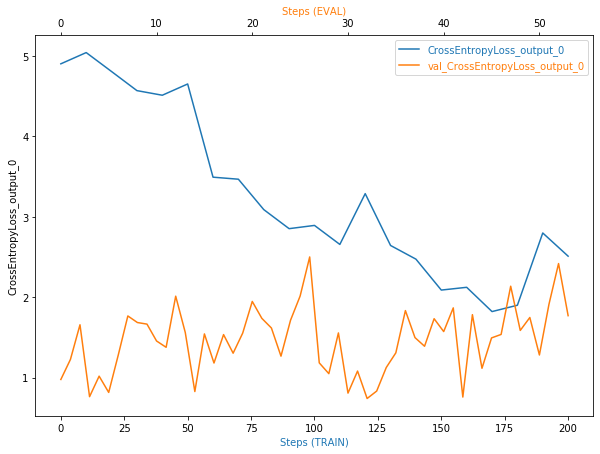

In [18]:
#plotting the tensor
plot_tensor(trial, "CrossEntropyLoss_output_0")

TODO: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?

TODO: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [19]:
# TODO: Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(" The profile output is in below location")
rule_output_path


 The profile output is in below location


's3://sagemaker-us-east-1-359070576608/pytorch-training-2022-01-20-17-04-21-689/rule-output'

In [20]:
! aws s3 ls {rule_output_path} --recursive

2022-01-20 17:11:40     380833 pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-01-20 17:11:39     229982 pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-01-20 17:11:34        191 pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-01-20 17:11:34       6751 pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-01-20 17:11:34        126 pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-01-20 17:11:34        129 pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-01-20 17:11:34       3789 pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-re

In [21]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-359070576608/pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east-1-359070576608/pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-359070576608/pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-359070576608/pytorch-training-2022-01-20-17-04-21-689/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-359070576608/pytorch-training-2022-01-20-17

In [22]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [25]:
import IPython

#IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [24]:
model_location=estimator.model_data
model_location

's3://sagemaker-us-east-1-359070576608/pytorch-training-2022-01-20-17-04-21-689/output/model.tar.gz'

In [26]:
from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor
#We need to define the serializer and deserializer that we will be using as default for our Prediction purposes
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

#If we need to override the serializer and deserializer then we need to pass them in an class inheriting the Predictor class and pass this class as parameter to our PyTorchModel
class ImgPredictor(Predictor):
    def __init__( self, endpoint_name, sagemaker_session):
        super( ImgPredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )
        
pytorch_model = PyTorchModel( model_data = model_location,
                            role = role,
                             entry_point= "endpoint.py",
                             py_version = "py36",
                             framework_version = "1.6",
                             predictor_cls = ImgPredictor
                            )

predictor = pytorch_model.deploy( initial_instance_count = 1, instance_type = "ml.g4dn.xlarge") #Using ml.t2.medium to save costs

-------!

In [28]:
endpoint_name = predictor.endpoint_name
endpoint_name

'pytorch-inference-2022-01-20-17-35-26-550'

Testing 4 Different images
Test no: 1


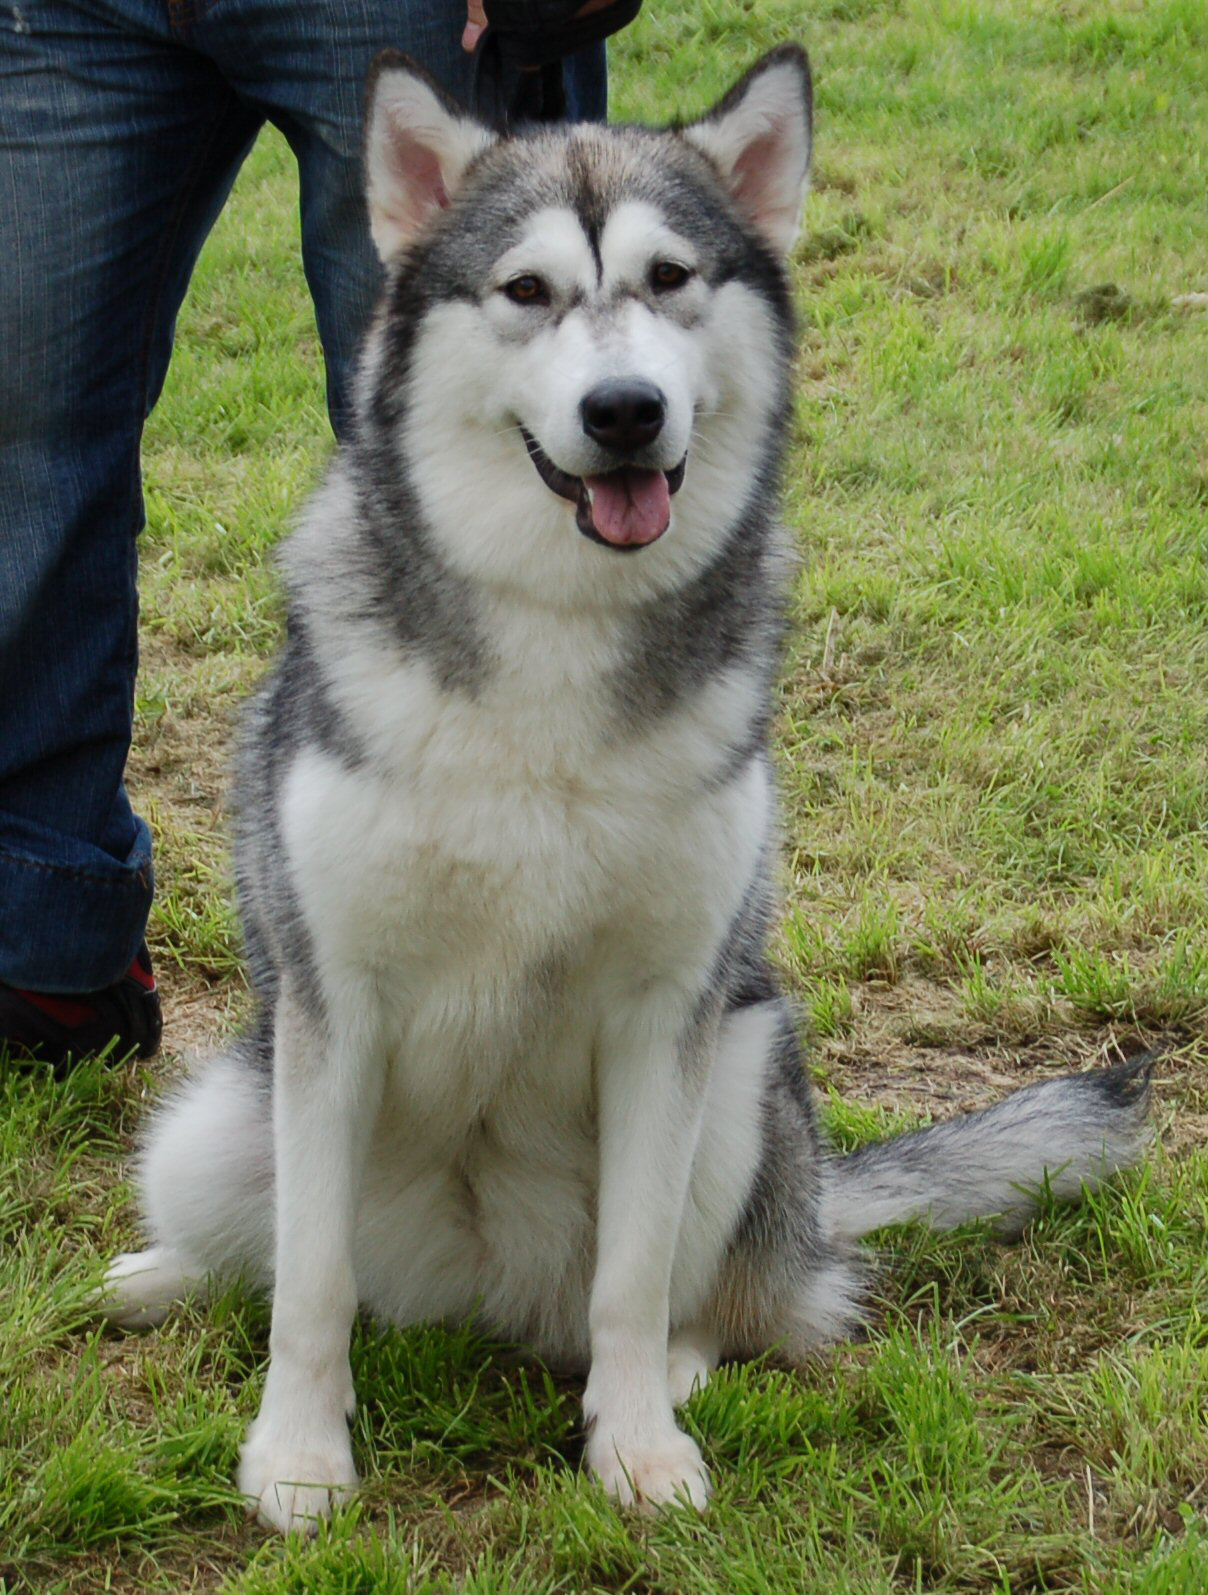

actual dog breed category no : 5
Response: [[ -9.64114952  -9.28393936 -12.02066803   2.48260498   5.19840765
    2.27674699  -8.87860584  -6.5073185  -15.43554783  -2.55118346
   -3.52151656  -6.23503208 -11.9029789   -5.68729591 -13.31670761
   -7.35036039  -9.60206699  -7.66781092  -6.53048706  -7.22627449
   -3.84310579  -5.58403826  -7.94242096  -2.43572068 -19.02106476
  -16.18811798 -14.11923122 -11.59213638  -3.56519651  -9.03665638
   -7.13960171  -5.26641941 -12.82331657 -10.47117043 -14.32624626
  -14.12392807 -11.8071661  -11.36607647  -3.28657794  -6.50881243
  -13.09376717  -7.23324776  -0.36955887 -11.16242695  -0.23666351
  -10.55491543 -11.57577991  -1.8475064   -6.65023422  -8.05325508
   -0.1457715   -9.41350365 -11.94198418  -4.45081425 -12.23153591
  -13.13431358  -7.08177042  -8.47103596 -12.62072468 -15.43332672
  -15.43108177  -9.84037495  -8.54164028 -14.96970749 -10.81264114
  -15.14854336  -0.68677294 -10.90520573  -5.33220148 -13.95858002
   -3.57116508 -14.

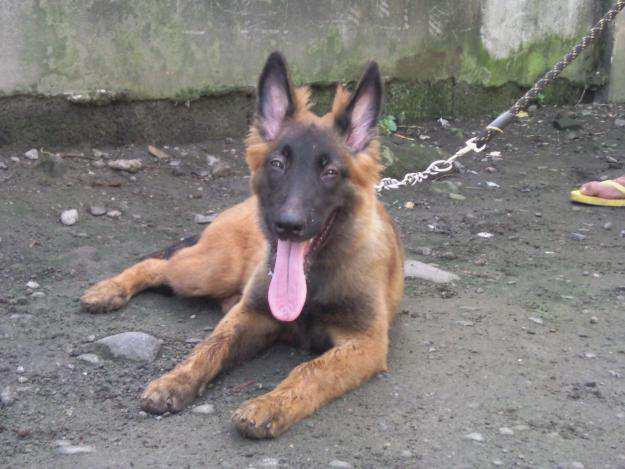

actual dog breed category no : 20
Response: [[-12.85943699 -12.93370628  -3.38387322  -7.6513257   -6.87989521
  -16.99679565 -13.14761353 -12.48052502 -14.26690578  -4.78108692
   -2.02077675  -9.98644733  -9.70329952  -7.4349699  -20.19561577
  -17.51391411 -19.40193176  -1.62523818 -12.81691456   3.33621931
   -2.90871525  -0.30161306 -11.12726879 -23.14261436 -17.19254112
  -22.59092522 -13.38516808 -10.89559364 -12.12907696  -4.68540573
  -10.71421242 -13.47844982 -12.70664406 -14.39970398 -13.84046745
  -15.38370419 -16.59382248 -10.71079254 -12.02719116 -18.47510147
  -11.39365578 -10.72338867  -5.64850187 -12.28546715  -4.17006731
  -26.80738258  -5.15588903 -10.23915958 -15.06467152 -10.83890247
   -9.07607555 -22.23054886 -20.5658226   -5.58355904  -9.55779266
   -7.91655064 -19.73822784 -17.56653976  -8.17280674 -15.11555481
  -17.90394211 -20.13977432 -19.21389389 -22.24483299 -11.14554214
  -10.37328529  -6.26823711  -2.0821104  -12.37890053  -8.87042522
    2.87804604 -12

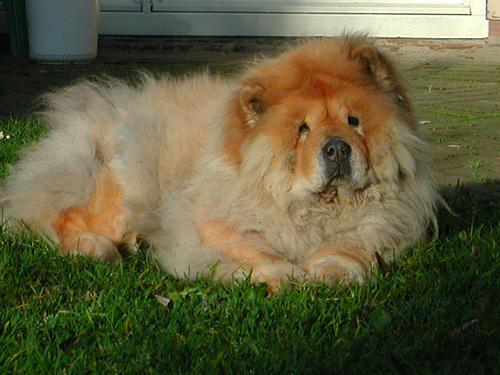

actual dog breed category no : 51
Response: [[-12.16249561  -6.13459682 -12.22393608  -2.04238534  -2.91351938
   -0.17375469 -12.1793766  -11.46004391 -14.66060734  -3.6952672
   -8.07793999  -8.11973286 -11.40071297 -11.61517334 -13.20219421
  -10.04731846 -10.27143478 -13.00061703  -8.37316418 -12.89985466
   -5.76017189 -11.05290031 -12.83128548  -4.21840954 -20.62282562
  -15.94174385 -10.7457056  -13.99834442  -6.85713291 -12.64263248
   -8.47550011 -11.69297123 -13.41195679 -15.81428528 -13.41761208
  -11.66325283 -12.22349644 -10.18225002  -8.77879906 -10.16604328
  -14.89224052  -6.81665373  -5.3134532  -14.13074589  -5.56453323
   -9.45399952 -12.62475491  -7.47477722  -7.29702473  -6.9292841
    3.15657258  -5.57155943  -8.27632046  -6.24165535 -13.25278282
  -13.15083408  -9.44460964  -7.85302544 -16.8704319  -14.79473972
   -9.8687048   -6.98591185 -10.06050777 -14.8776989  -16.56971931
  -12.67875099  -1.734635   -11.03433132 -10.0190773  -17.05617523
   -6.85429144 -16.2

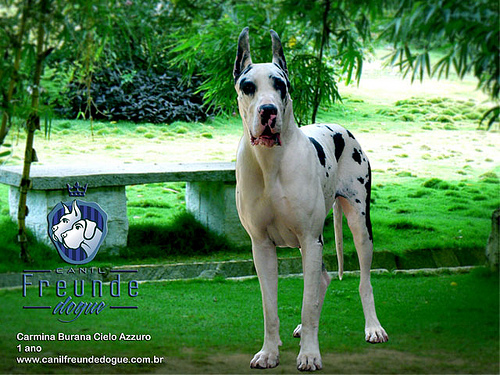

actual dog breed category no : 78
Response: [[-1.44629869e+01 -1.17397528e+01 -5.56787014e+00 -4.36793947e+00
  -5.40538692e+00 -9.21984959e+00 -4.19837773e-01  4.38152164e-01
  -7.19000387e+00 -1.71487963e+00 -6.28654957e+00 -5.17528915e+00
  -1.81791649e+01 -7.55057096e-01 -1.97992730e+00 -1.37724590e+00
  -1.08352919e+01 -1.24082642e+01 -3.24797845e+00 -8.56968498e+00
  -1.60064507e+01 -1.40471191e+01 -7.23618412e+00 -9.56352997e+00
  -8.44989300e+00 -1.26273823e+01 -8.48409557e+00 -4.52778149e+00
  -5.23105860e+00 -1.13416634e+01 -1.67270616e-01 -1.70590484e+00
  -1.28388042e+01 -1.41980201e-02 -1.34319496e+01 -1.35399027e+01
  -3.13735557e+00 -1.35941973e+01  3.69239479e-01 -2.93617940e+00
  -7.22634363e+00 -1.22865143e+01 -1.67833281e+00 -1.74113905e+00
  -1.77905333e+00 -9.09309387e+00 -6.49816418e+00 -5.08062792e+00
  -2.13305211e+00 -5.88948488e+00 -1.43535252e+01 -6.61791611e+00
  -9.93157387e+00 -7.89035416e+00 -9.63396454e+00 -5.95844316e+00
   5.28280914e-01 -1.33043652e+0

In [3]:
import json
import base64
import PIL
from PIL import Image
import io
import numpy as np
import boto3
import os
# We will be using the AWS's lightweight runtime solution to invoke an endpoint.
runtime= boto3.client('runtime.sagemaker')
test_image_path = "./test_images"
test_images = [ 'TestImg_Alaskan_malamute.jpg', 'TestImg_Belgian_malinois.jpg', 'TestImg_Chow_chow.jpg','TestImg_Great_dane.jpg' ]
test_images_actual = [5, 20, 51,78 ]
for index in range(len(test_images) ):
    test_img = test_images[index]
    actual_breed_category = test_images_actual[index] 
    print("Testing 4 Different images")
    test_file_path = os.path.join(test_image_path,test_img)
    with open(test_file_path , "rb") as f:
        payload = f.read()
        print(f"Test no: {index+1}")
        display(Image.open(io.BytesIO(payload)))
        print(f"actual dog breed category no : {actual_breed_category}")
        response = runtime.invoke_endpoint(EndpointName='pytorch-inference-2022-01-20-17-35-26-550',
                                       ContentType='image/jpeg',
                                       Body=payload)
        response_body = np.asarray(json.loads( response['Body'].read().decode('utf-8')))        
        print(f"Response: {response_body}")        
        predicted_dog_breed = np.argmax(response_body,1) + 1 #We need to do plus 1 as index starts from zero and prediction is zero-indexed
        print(f" predicted Response/Inference for the above image is : {predicted_dog_breed}")

## From the result of the test images, the model was able to predict the breed of the first three images correctly.

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()